Looking into building a TOI-700 SED for Tomoaki.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Start with a Linsky EUV profile.

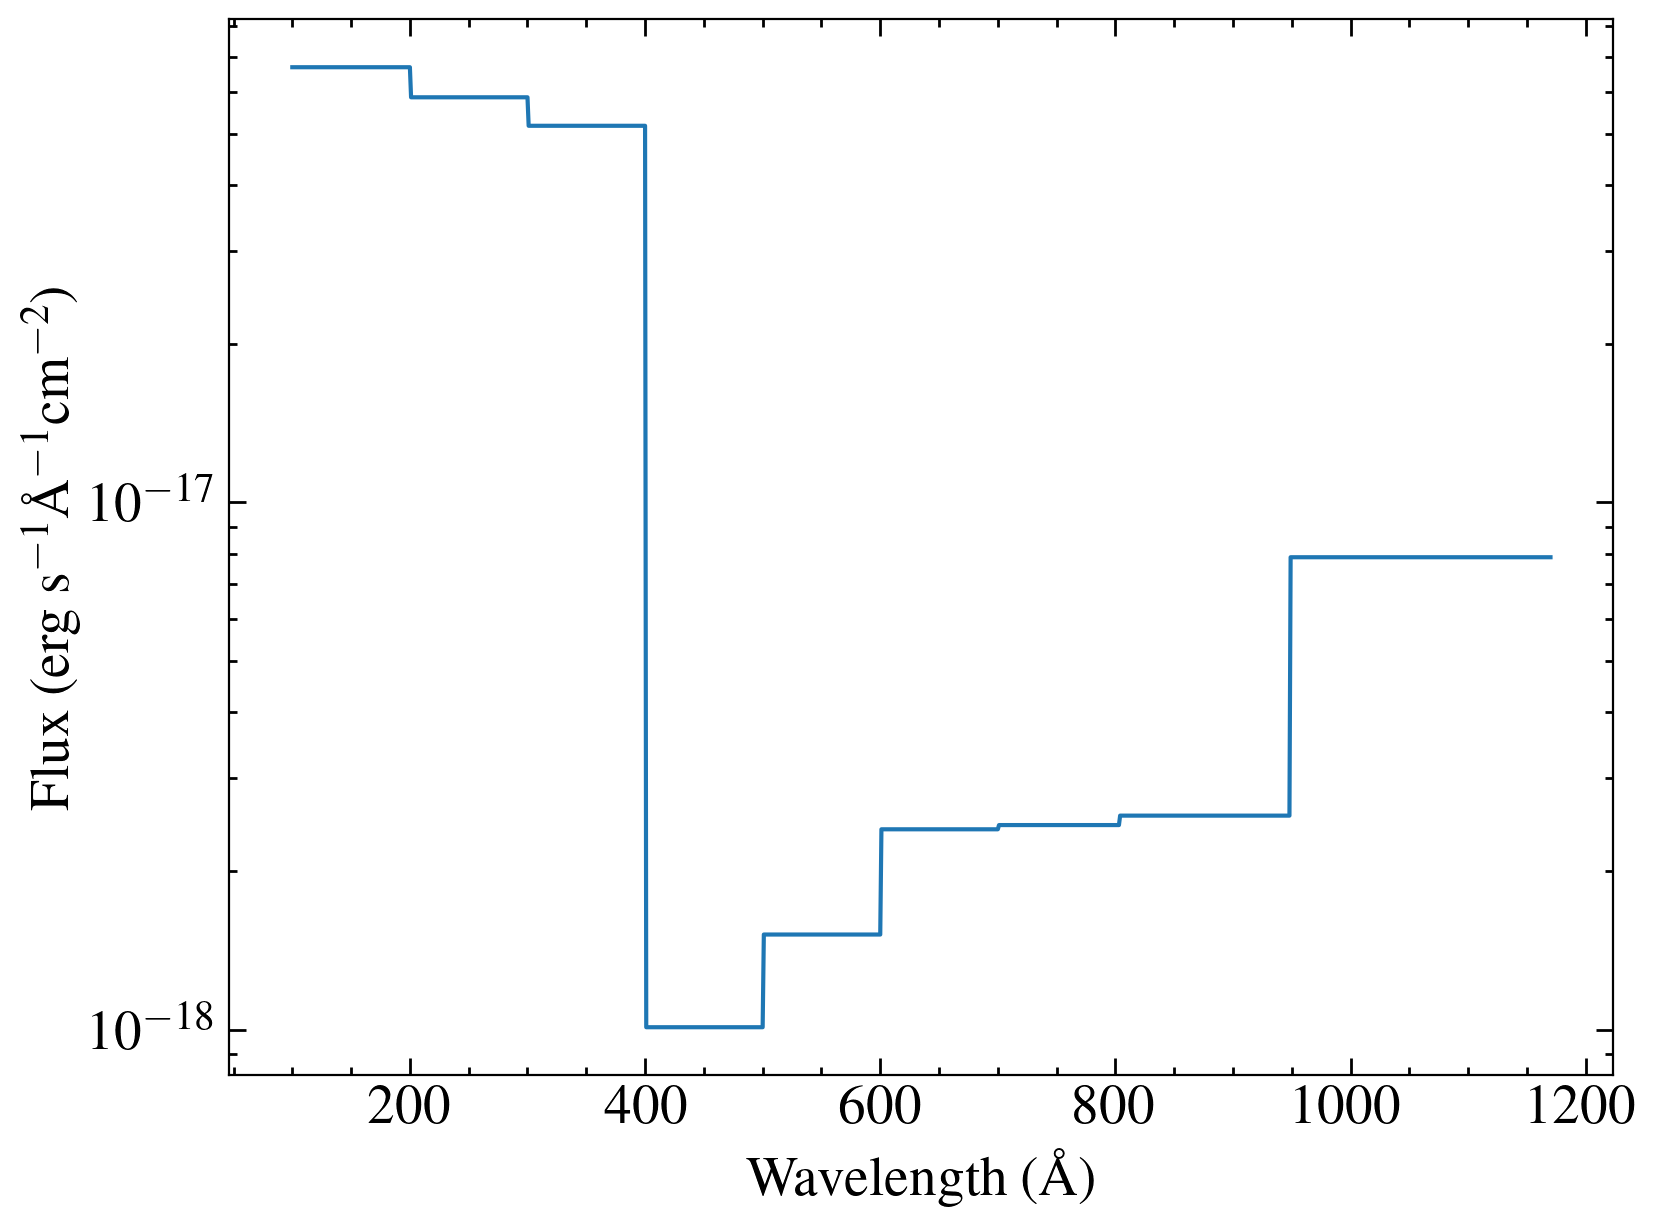

In [2]:
import linsky_euv
star = 'TOI-700'
lya_flux = 2.07e-14 
distance = 31.28
w_euv, f_euv = linsky_euv.euv_estimator(lya_flux, distance, star=star, spt='M', save=True, plot=True)

Check that makes sense...yes.

In [3]:
# # mmpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_multi_multi_gj674_broadband_v24_var-res-sed.fits'
# mmpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/gj667c/hlsp_muscles_multi_multi_gj667c_broadband_v22_var-res-sed.fits'
# mmdata = fits.getdata(mmpath, 1)
# mmw, mmf, mme= mmdata['WAVELENGTH'], mmdata['FLUX'], mmdata['ERROR']

In [4]:
# d_gj674 = 4.552775
# d_gj667c = 7.242897071914

# # scale = (d_gj674/distance)**2
# scale = (d_gj667c/distance)**2

# plt.plot(mmw, mmf*scale)
# plt.plot(w_euv, f_euv)

# plt.xlim(w_euv[0], w_euv[-1])
# plt.ylim(0, 1e-16)

Got the rest of the spectrum from Giada Arney.

In [5]:
uvpath = '/media/david/2tb_ext_hd/hddata/toi-700/TOI700_SED_v2.txt'
uvw, uvf = np.loadtxt(uvpath, unpack=True, delimiter=',')

(-1e-18, 3e-16)

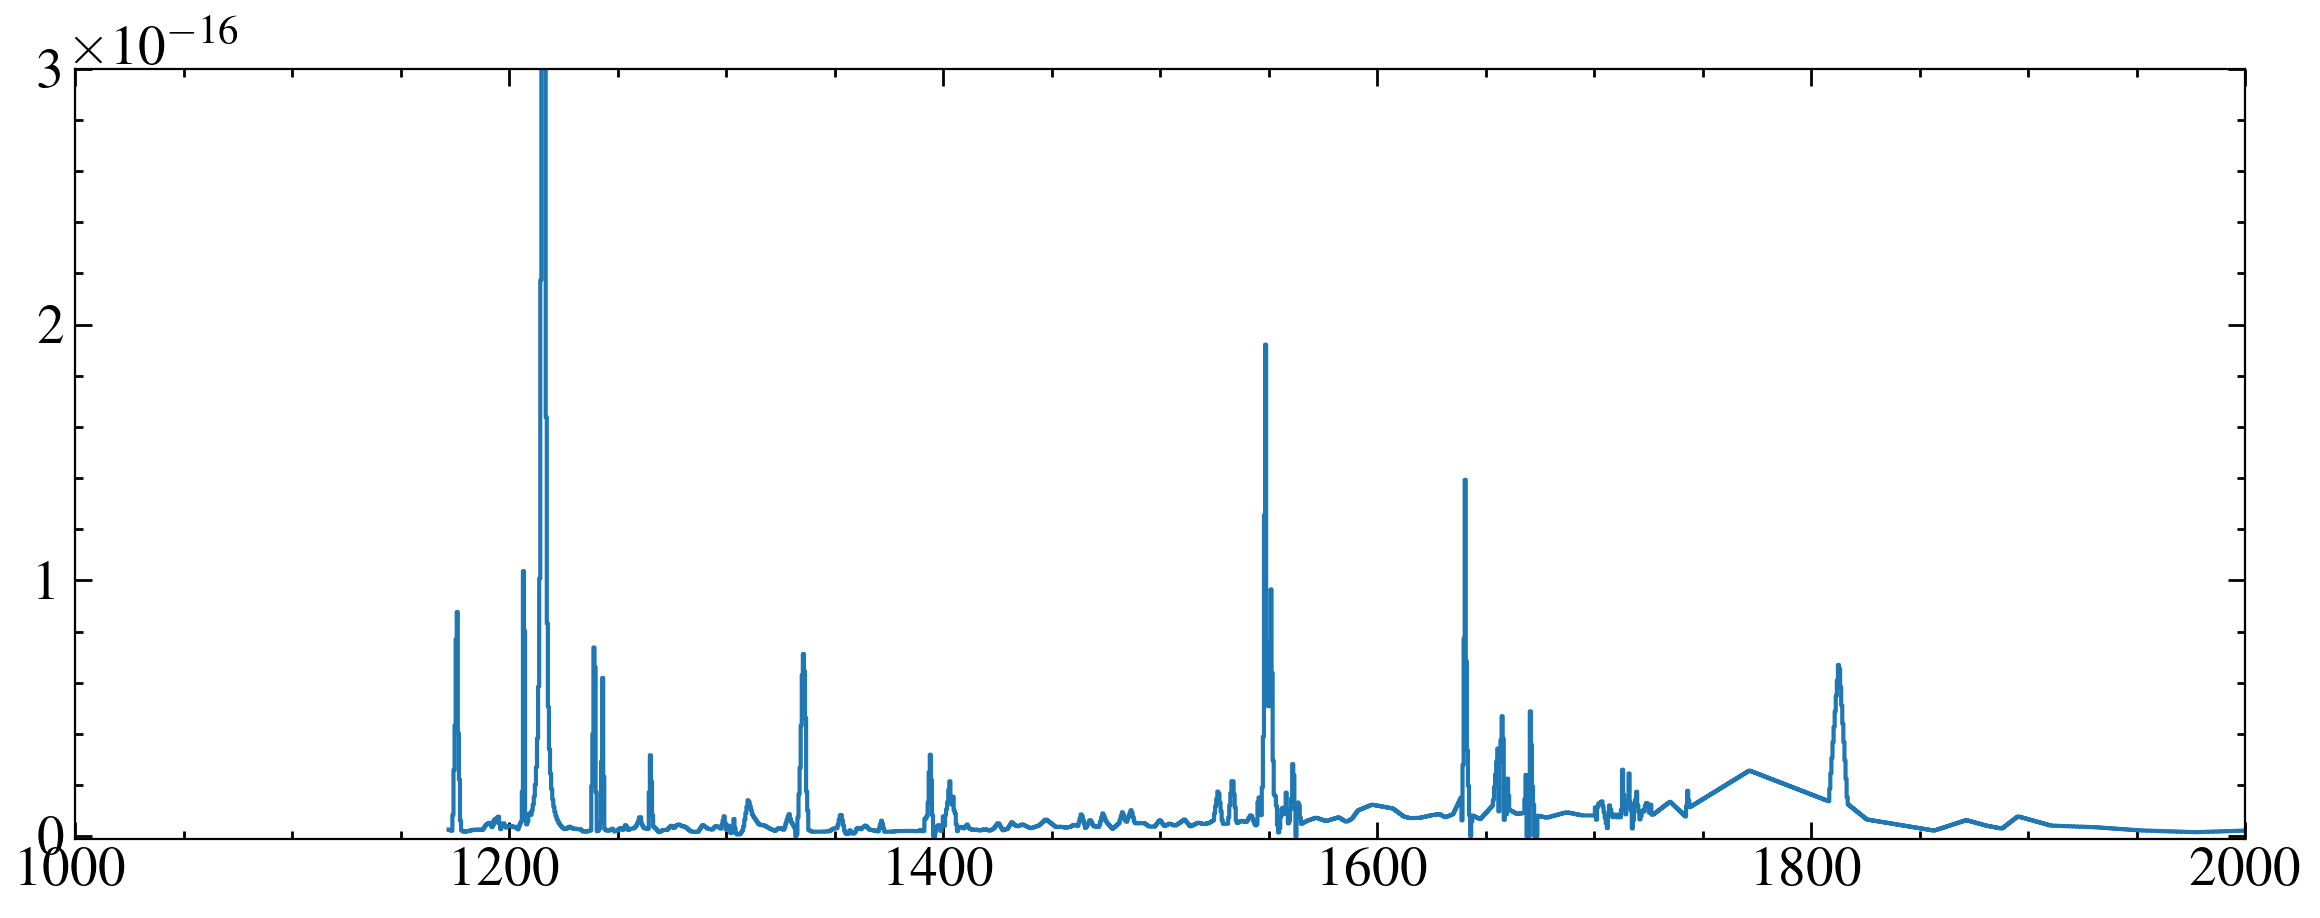

In [6]:
plt.step(uvw, uvf, where='mid')
plt.xlim(1000, 2000)
plt.ylim(-0.1e-17, 3e-16)

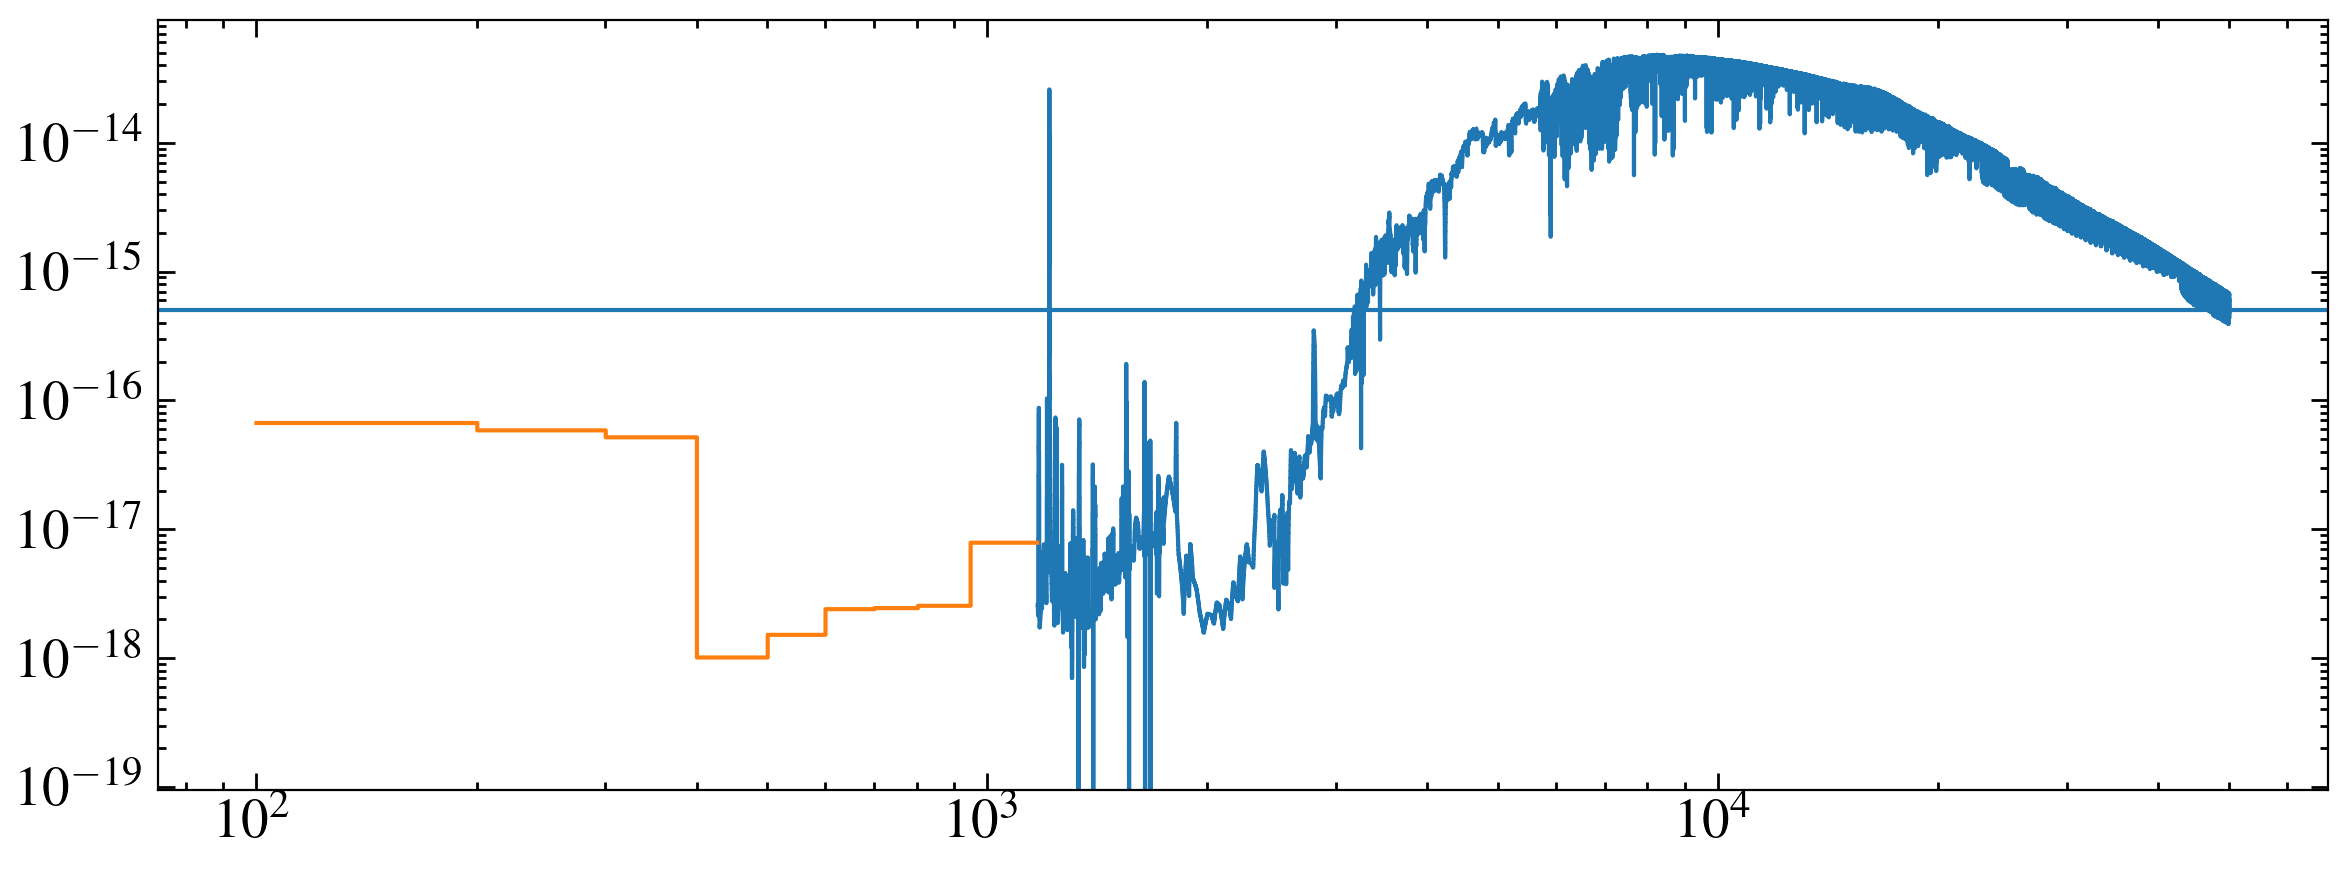

In [7]:
fig, ax = plt.subplots()

ax.step(uvw, uvf, where='mid')

ax.step(w_euv, f_euv, where='mid')


# ax.axhline(4.077e-14/15) # pimms output, bit high, maybe wrong X-ray source

ax.axhline(7.5E-15 /15) # pimms output, better estimate, massive errorbars though.



ax.set_yscale('log')
ax.set_xscale('log')



XRT analysis.

In [8]:
counts = 39 
counts_e = 6
bkg = np.mean([20, 21, 38, 17])
bkg_e = np.std([20, 21, 38, 17])
texp = 39131.674

source = counts- bkg
error = (counts_e**2 + bkg_e**2)**0.5
print(source, error)

rate = source/texp
rate_e = error/texp

print(rate, rate_e)
print(rate/rate_e)

15.0 10.173494974687902
0.0003833211939770325 0.00025998108270778046
1.4744195615489712


Use parameters from GJ 436. Pimms says fx = 1e-14 in 0.3-10 kev range

In [9]:
from  xspec import *

In [10]:
mod = Model('apec*phabs', setPars={1:0.4, 2:0.4, 5:1e-3})
AllModels.setEnergies(".3 10. 1000")
flux = AllModels.calcFlux(".3 10")
print(flux)
fluxnum = mod.flux[0]
print('fluxnum:', fluxnum)
norm = 1e-14/fluxnum
print('norm:', norm)
# Plot("model")
# xVals = Plot.x()
# yVals = Plot.model()
# plt.plot(xVals, yVals)
mod.setPars({4:norm})


None
fluxnum: 1.205904695533974e-09
norm: 8.292529282815345e-06
Reading APEC data from 3.0.9


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      0.400000     +/-  0.0          
   2    1   apec       Abundanc            0.400000     frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/


Models will now use energy array created from:
   0.1 - 2.5   2400 linear bins

None
5.309889837781652e-30 erg / (s cm2)
 Upper range bound          2.5 reset by matrix bound to          2.5
 Model Flux 1.7366e-05 photons (1.2346e-14 ergs/cm^2/s) range (0.10000 - 2.5000 keV)


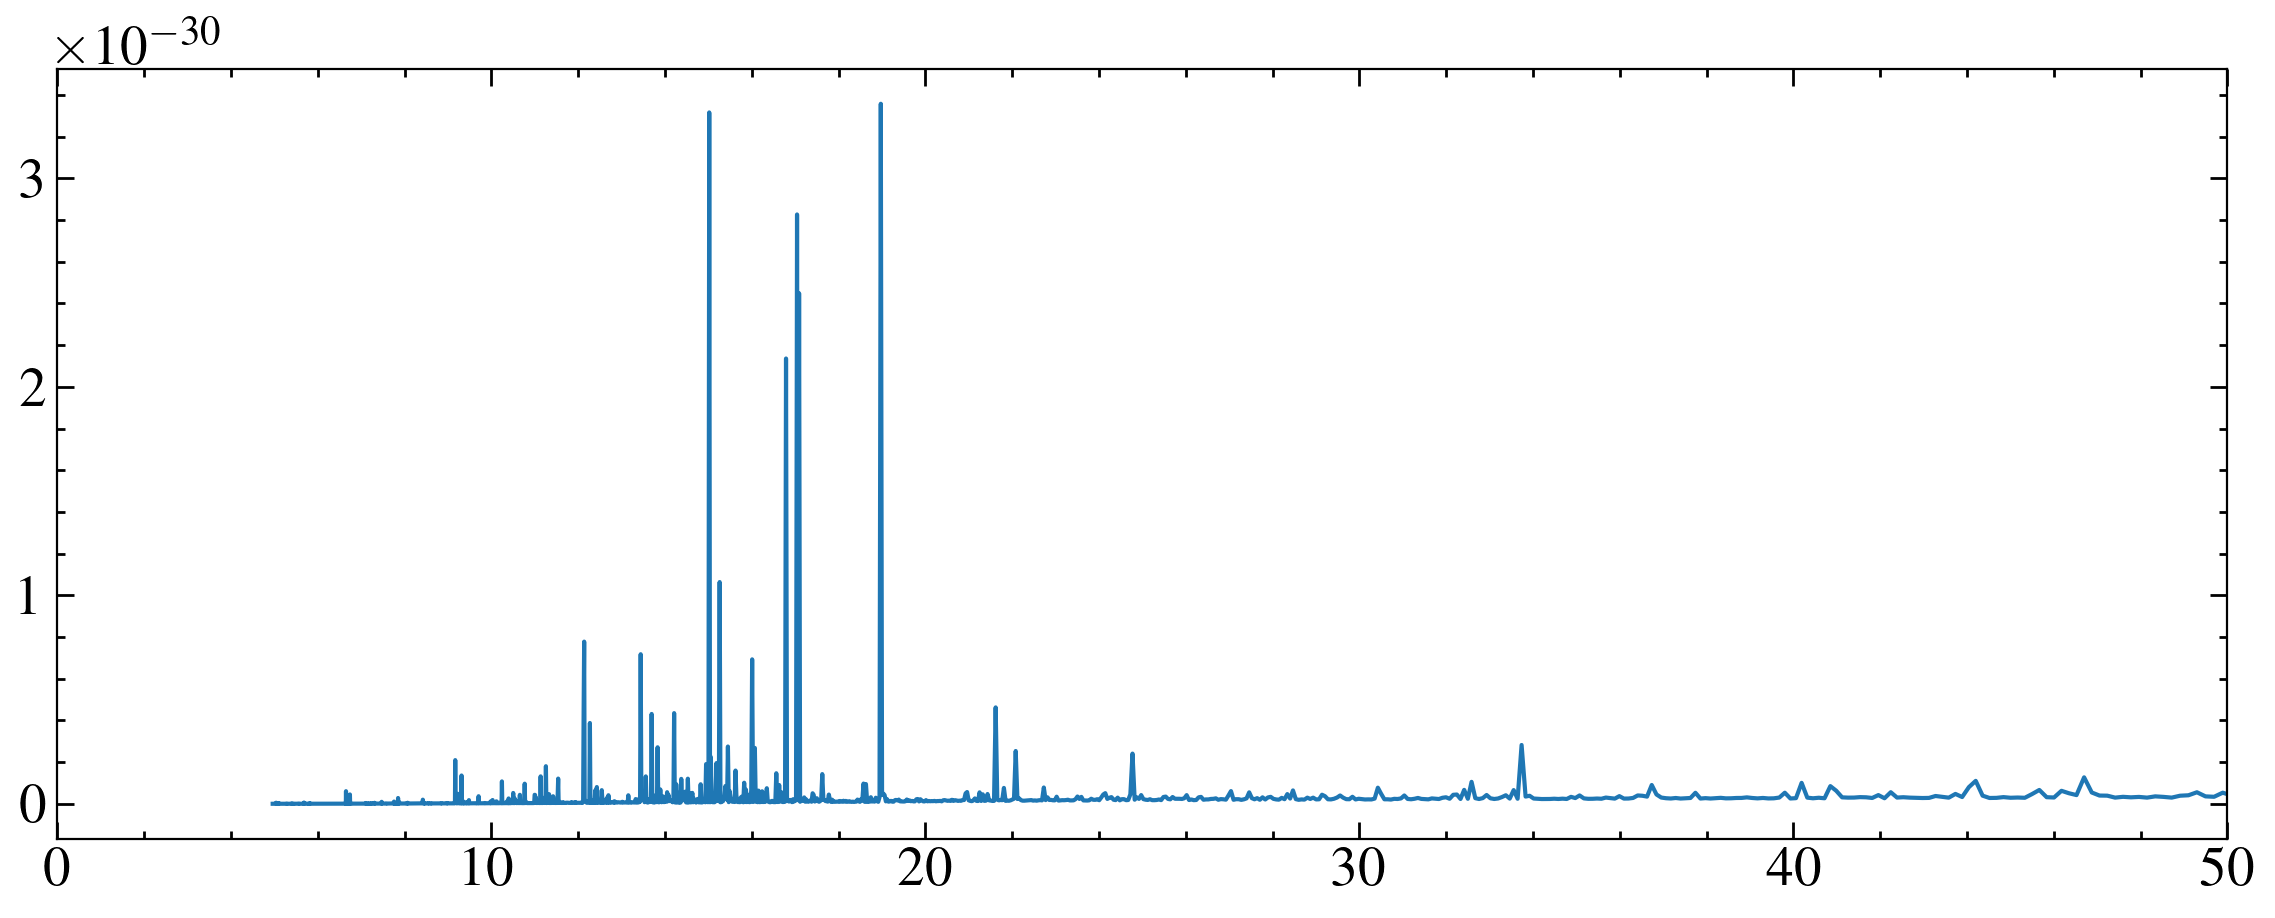

In [14]:
Plot.device = '/null'
AllModels.setEnergies("0.1 2.5 2400")
Plot("model")
Plot.xAxis ='angstrom'
xVals = Plot.x()[::-1]
yVals = Plot.model()[::-1]

# print(yVals)
# print(xVals)
# wx = (xVals*u.keV).to(u.AA, equivalencies=u.spectral())
wx = xVals*u.AA
# print(wx)
# fx = yVals
fx  = (yVals * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
# fx = np.array(yVals)*1.9864459e-8/wx
# wx, fx = wx[::-1], fx[::-1]
print(AllModels.calcFlux(".1 2.5"))

print(np.trapz(fx, wx))
plt.plot(wx, fx)
plt.xlim(0, 50)
# flux = AllModels.calcFlux(".3 10")
# print(flux)
plt.show()
# savdat = Table([wx[::-1], fx[::-1]], names=['WAVELENGTH', 'FLUX'])
# ascii.write(savdat, 'fake_apecs/{}apec.txt'.format(star), format='basic', overwrite=True)    

Ok for some reason pyxspec is broke.

5.309889837781652e-30 erg / (s cm2)


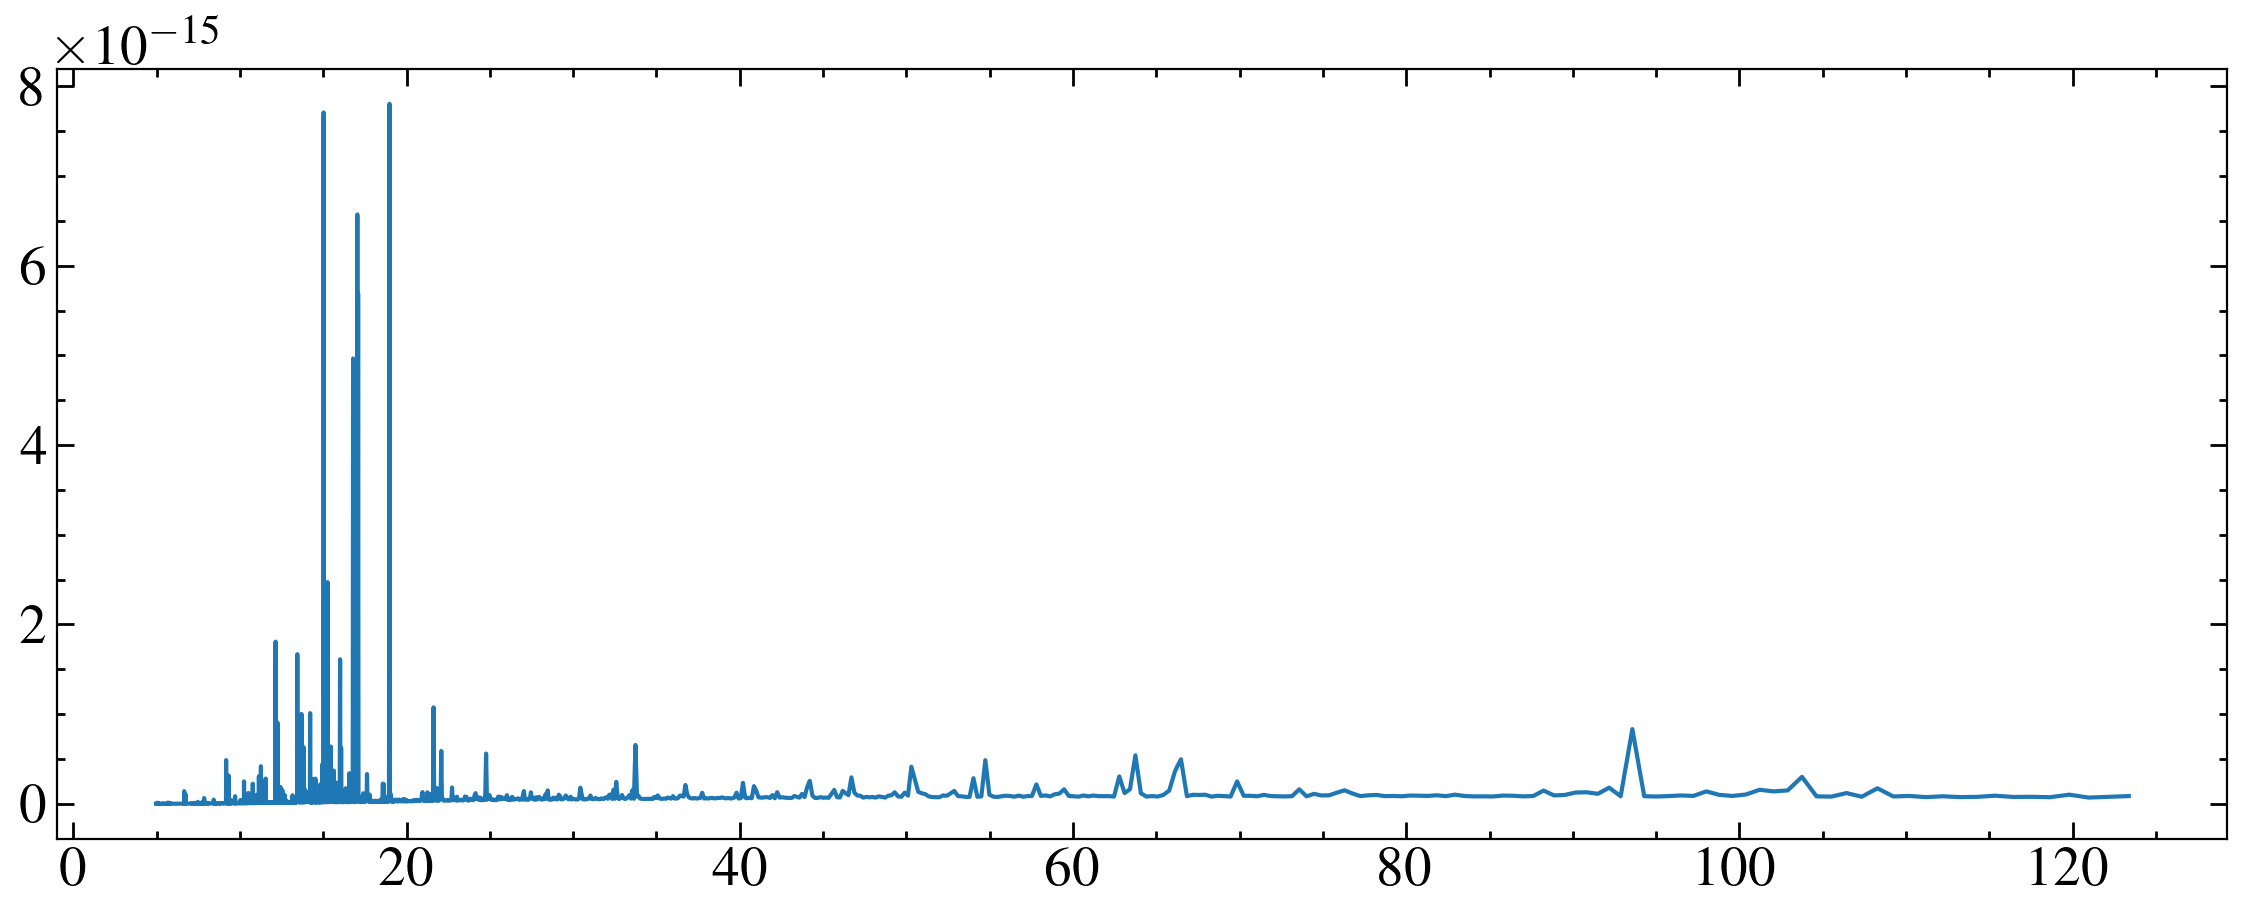

In [38]:
targf = 1.2346e-14
intf = np.trapz(fx, wx)
print(intf)

plt.plot(wx, fx*(targf/intf))

wxi = wx.value
fxi = (fx*(targf/intf)).value

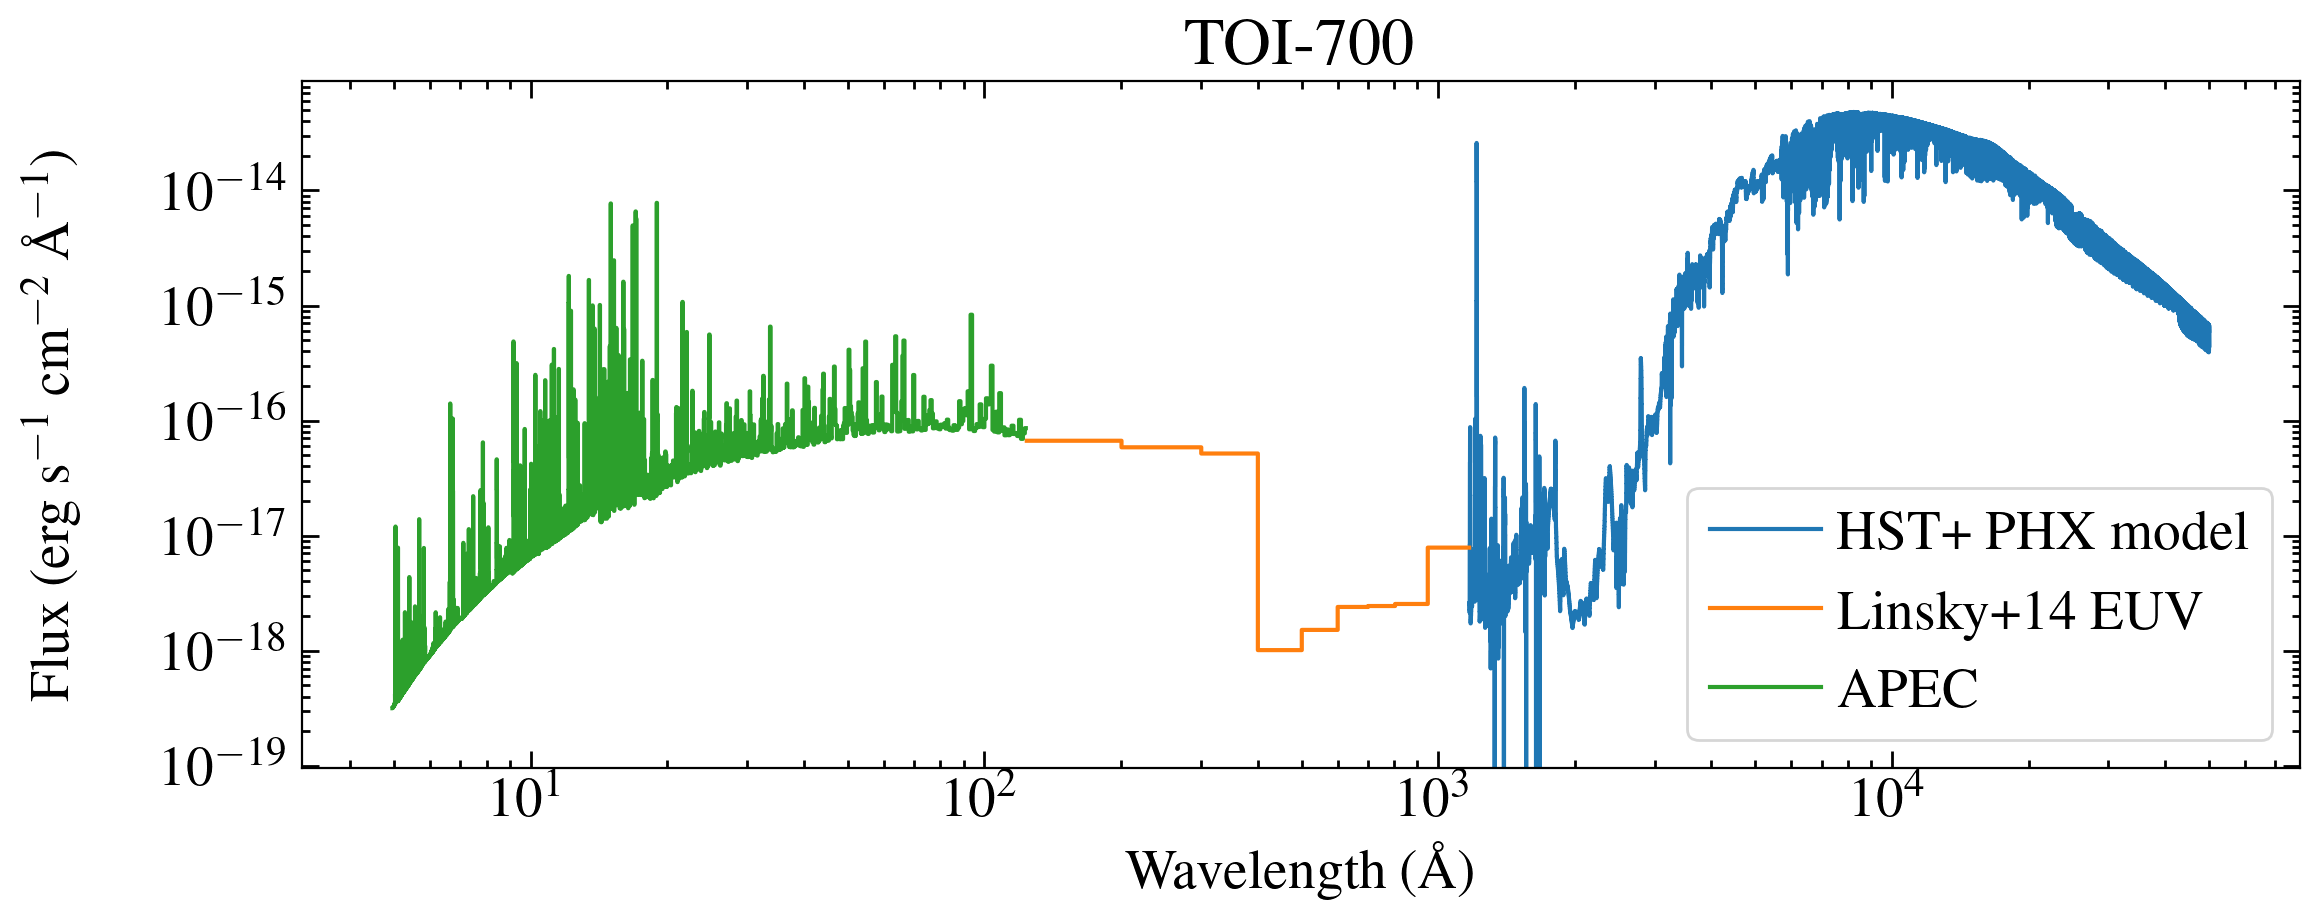

In [51]:
mask = (w_euv > wxi[-1]) & (w_euv < uvw[0])

fig, ax = plt.subplots(figsize=(12, 5))

ax.step(uvw, uvf, where='mid', label = 'HST+ PHX model')

ax.step(w_euv[mask], f_euv[mask], where='mid', label='Linsky+14 EUV')

ax.step(wxi, fxi, where='mid', label='APEC')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(frameon=True, loc=4)
ax.set_title('TOI-700')

ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', labelpad=30)

fig.tight_layout()
fig.savefig('plots/toi-700_sed.pdf')

In [49]:
allw, allf = np.hstack((wxi, w_euv[mask],  uvw)), np.hstack((fxi, f_euv[mask],  uvf))

# plt.plot(allw, allf)
# plt.yscale('log')
# plt.xscale('log')

savdat = Table([allw*u.AA, allf*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'FLUX'])
savdat.write('models/toi-700_sed.ecsv', format='ascii.ecsv', overwrite=True)

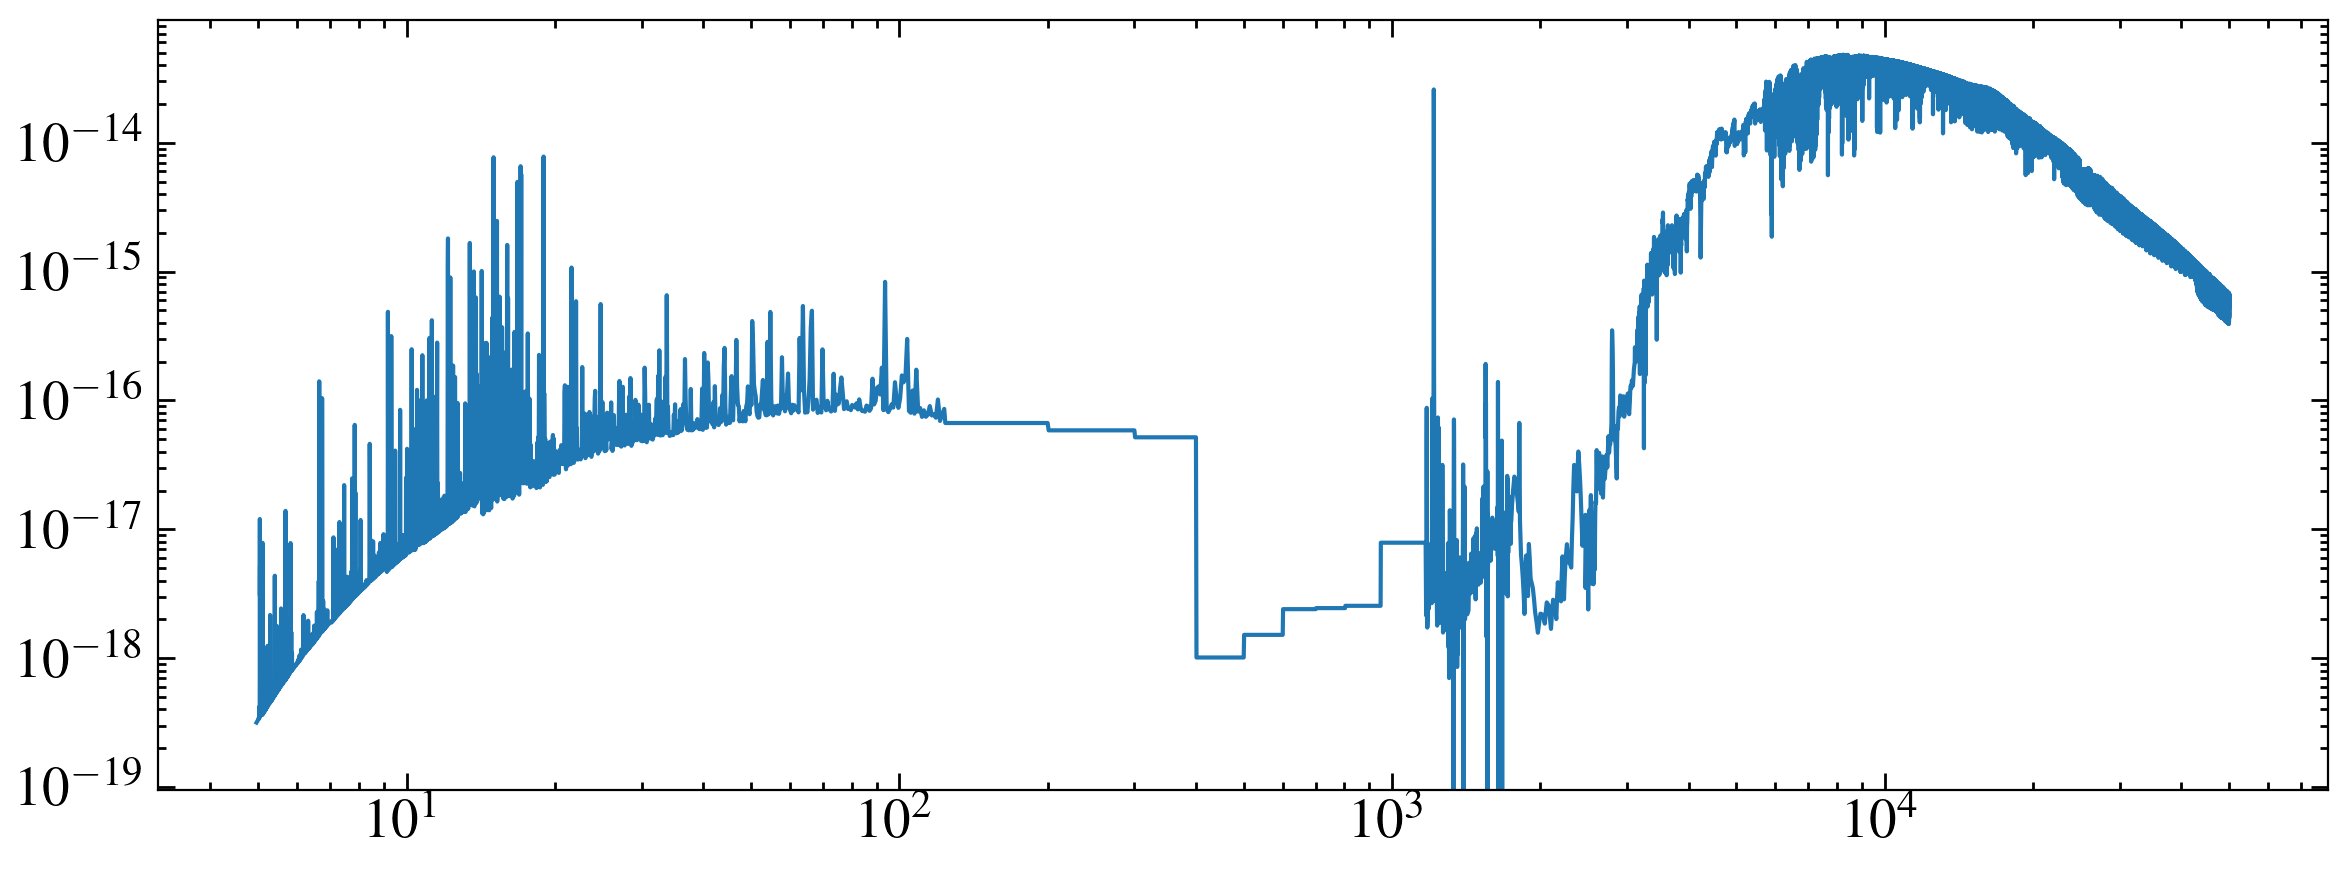

In [54]:
data = Table.read('models/toi-700_sed.ecsv')
plt.plot(data['WAVELENGTH'], data['FLUX'])
plt.yscale('log')
plt.xscale('log')